##### Copyright 2025 Google LLC.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Outfit Assistant 🧤


<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Outfit_Assistant.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>


<table>
  <tr>
    <!-- Author Avatar Cell -->
    <td bgcolor="#d7e6ff">
      <a href="https://github.com/Aarchi-07" target="_blank" title="View Aarchi's profile on GitHub">
        <img src="https://github.com/Aarchi-07.png?size=100"
             alt="Giom-V's GitHub avatar"
             width="100"
             height="100">
      </a>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#d7e6ff">
      <h2><font color='black'>This notebook was contributed by <a href="https://github.com/Aarchi-07" target="_blank"><font color='#217bfe'><strong>Aarchi</strong></font></a>.</font></h2>
      <h5><font color='black'><a href="URL"><font color="#078efb">Github</font></a> - See <a href="https://github.com/Aarchi-07" target="_blank"><font color="#078efb"><strong>Aarchi's</strong></font></a> other notebooks <a href="https://github.com/search?q=repo%3Agoogle-gemini%2Fcookbook%20%22Aarchi%22&type=code" target="_blank"><font color="#078efb">here</font></a>.</h5></font><br>
      <!-- Footer -->
      <font color='black'><small><em>Have a cool Gemini example? Feel free to <a href="https://github.com/google-gemini/cookbook/blob/main/CONTRIBUTING.md" target="_blank"><font color="#078efb">share it too</font></a>!</em></small></font>
    </td>
  </tr>
</table>

#### The notbook is the implementation of an outfit assistant that uses Gemini's multimodality to recommend outfits based on the following factors:

- User's style preference,
- Occasion, and
- Weather data

The `style preference` and the `occasion` would be entered by the user and to get the weather data, the notebook uses the Grounding with Google Search.

## Setup

### Install SDK

In [2]:
%pip install -U -q "google-genai>=1.0.0"

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key (or OAuth if using Vertex AI). The model is now set in each call.

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-3-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

### Global Digital Closet

This section defines the digital wardrobe by storing direct links of clothing items. These images serve as the "visual inventory" that Gemini will scan to recommend outfits.

In [16]:
import re
from google.genai import types

# Links for the ai generated clothing items
outfit_links = [
    # Lowerwear image links
    "https://i.ibb.co/k2WXFvy5/image1.png",
    "https://i.ibb.co/4g2NkQnF/image2.jpg",
    "https://i.ibb.co/FkX3DGYN/image3.png",
    "https://i.ibb.co/6GVrm2Y/image4.jpg",
    "https://i.ibb.co/svgz8KR2/image5.png",
    "https://i.ibb.co/8D9pSvFt/image6.jpg",
    "https://i.ibb.co/bjX8nWLN/image7.jpg",
    "https://i.ibb.co/tT0WVwgV/image9.jpg",
    "https://i.ibb.co/HkqLfXm/image8.jpg",
    "https://i.ibb.co/Mk7jqBTH/image10.jpg",
    # Upperwear image links
    "https://i.ibb.co/dJr8nvys/clothing-image11.jpg",
    "https://i.ibb.co/rGZVFBKc/clothing-image12.jpg",
    "https://i.ibb.co/0PfxGYV/clothing-image13.jpg",
    "https://i.ibb.co/jPNGY6DK/clothing-image14.png",
    "https://i.ibb.co/DfHqDsRD/clothing-image15.jpg",
    "https://i.ibb.co/9m32nQd6/clothing-image16.png",
    "https://i.ibb.co/mF9np1f0/clothing-image17.jpg",
    "https://i.ibb.co/YBZW88Yh/clothing-image18.jpg",
    "https://i.ibb.co/hFC2xMtL/clothing-image19.png",
    "https://i.ibb.co/wFm03L4p/clothing-image20.jpg",
    "https://i.ibb.co/bg2kJp0P/clothing-image21.jpg",
    ]


To send images to Gemini, Convert the URLs into actual image data. This step downloads each image from the wardrobe list and converts it into a PIL object.

In [17]:
from typing import List
import requests
from io import BytesIO
from PIL import Image
from pydantic import BaseModel, Field

image_objects = []
for url in outfit_links:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    image_objects.append(img)


### Gemini Stylist Chat Interface

- Initialize chat with system instructions and ensures the final output includes machine-readable JSON.
- Enable the Google Search tool here, allowing the model to ground its outfit recommendations in real-time weather data during the conversation.

In [18]:
system_instruction = """
  You are a professional fashion stylist. You have access to a wardrobe of images.

  YOUR MISSION:
  1. Greet the user and ask for their current location (to check weather).
  2. Once you have the location, ask for the specific occasion (e.g., office, party).
  3. ONLY after getting BOTH, use your Google Search tool to check the weather.
  4. Suggest a complete outfit (Upperwear and Lowerwear) from the provided images.

  OUTPUT RULES:
  - Provide a brief, 2-sentence stylist's justification.
  - At the very end, strictly provide the selection in this JSON format:

  ```json
  {
    "images": List[int] # List of zero based index for the suggested clothing
  }
  ```
"""

chat = client.chats.create(
    model=MODEL_ID,
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
        tools=[types.Tool(google_search=types.GoogleSearch())],
    )
)

Initiate a continuous, interactive session where the Gemini remembers your context (location and preferences) across multiple turns. The loop automatically handles the conversation flow, displaying the stylist's advice and rendering the recommended outfit images until you choose to exit.

🤖 Fashion Assistant: Hello! I'd love to help you pick an outfit.Where are you located?
You: new york


Hello there! I'm your personal fashion stylist. I see you're in New York.

To help me pick the perfect outfit for you, could you please tell me what specific occasion you're dressing for? For example, are you heading to the office, a casual outing, a party, or something else?

You: at christmas party


Hello! It's great to hear you're heading to a Christmas party in New York. To make sure you're perfectly dressed for the occasion, could you please confirm what specific occasion you're dressing for? For example, are you heading to the office, a casual outing, a party, or something else?

Ah, I see you're off to a Christmas party! Let's get you styled.
New York in December is quite cold, with average temperatures ranging from 0°C to 8°C (32°F to 46°F), and there's often a chance of snow and brisk winds. For a Christmas party, you'll want something that is both warm and elegantly festive.

I recommend a classic and sophisticated ensemble: the black suit jacket paired with a white shirt and tie, complemented by tailored black dress pants. This outfit is perfect for an elegant Christmas party in chilly New York, offering both warmth and a polished look suitable for the festive occasion.


✨ Recommended Look:


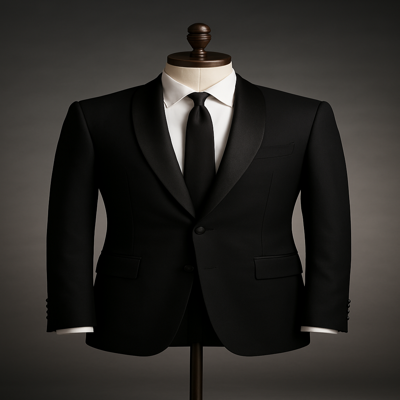

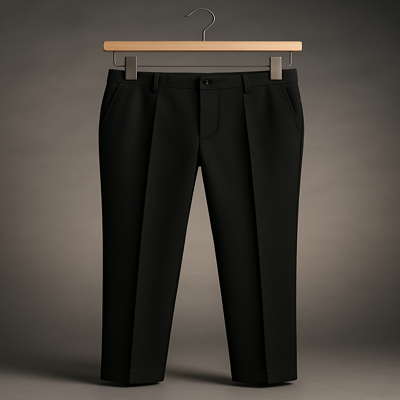


Would you like to try another occasion? (if not, type exit/ quit/ bye)
You: exit


In [19]:
import json
import re
from IPython.display import Markdown, display

print("🤖 Fashion Assistant: Hello! I'd love to help you pick an outfit.Where are you located?")
is_first_message = True

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        break

    if is_first_message:
        response = chat.send_message([user_input, *image_objects])
        is_first_message = False
    else:
        response = chat.send_message(user_input)

    clean_text = re.sub(r"```json\s*[\s\S]*?```", "", response.text).strip()
    display(Markdown(clean_text))

    json_match = re.search(r"```json\s*(.*?)\s*```", response.text, re.DOTALL)
    if json_match:
        try:
            indices = json.loads(json_match.group(1))["images"]
            print("\n✨ Recommended Look:")
            for idx in indices:
                if 0 <= idx < len(image_objects):
                    display(image_objects[idx].resize((400, 400)))
            print("\nWould you like to try another occasion? (if not, type exit/ quit/ bye)")
        except Exception as e:
            print(f"Error displaying images: {e}")

## More interesting demos here 👇

- [Analyze a Video - Summarization 🎥](https://github.com/google-gemini/cookbook/blob/main/examples/Analyze_a_Video_Summarization.ipynb)

- [Illustrating a book using Imagen 3 🌌](https://github.com/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb)

- [Guess the shape: Triangle, square, pentagon,? 💭](https://github.com/google-gemini/cookbook/blob/main/examples/Guess_the_shape.ipynb)
